## command untuk local machine:

jupyter notebook --port=58888 --NotebookApp.allow_origin='https://colab.research.google.com' --NotebookApp.port_retries=0


## Data explanation

In [ ]:
all the data is using csv file one for each utterance. 
every data file has frame, face_id, timestamp, landmark confidence, and landmark recognition success.

the landmarks are 68 3d positions with scheme:
  
 

<img src='https://github.com/TadasBaltrusaitis/OpenFace/raw/master/imgs/landmark_scheme_68.png' width="300">



format:

    X_0, X_1, X_2, ..., X_67
    Y_0, Y_1, Y_2, ..., Y_67
    Z_0, Z_1, Z_2, ..., Z_67

the landmark position data is distance of displacement of each axis from the ground value which is the position when speaker is silent. we choose the frame 1 as ground/silent position so the data will be for ex:

              X_0   X_1
    frame 1   -72   -45
    frame 2   0.2   0.1

the actual values of frame 2 are 

    X_0 = (-72+0.2), X_1 = (-45+0.1)

speech feature is represented byd 13 coefficient of MFCC:
    mfcc_0, mfcc_1, ..., mfcc_12


## Import Modules

In [1]:
import os
import random
import gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import multiprocessing as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, Flatten
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
import time

plt.style.use('fivethirtyeight')
data_dir = "/home/alkhemi/Documents/thesis/npy_data_s19_mfcc39_landmark107_pastX0_futureX0_pastY0_futureY0/"
model_dir = "/home/alkhemi/Documents/thesis/saved_model/"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load np data

In [2]:
# load data
X_train = np.load(data_dir+"X_train.npy")
Y_train = np.load(data_dir+"Y_train.npy")
X_test = np.load(data_dir+"X_test.npy")
Y_test = np.load(data_dir+"Y_test.npy")
print("train", "X shape:", X_train.shape, "Y shape:", Y_train.shape)
print("test", "X shape:", X_test.shape, "Y shape:", Y_test.shape)
# print("train", "x min:", X_train.min(), "x max:", X_train.max())
# print("train", "y min:", Y_train.min(), "y max:", Y_train.max())

train X shape: (160191, 1, 39) Y shape: (160191, 1, 107)
test X shape: (17800, 1, 39) Y shape: (17800, 1, 107)


## Create Scaler (one time only)

def MinMaxScaler(arr,min,max):
  new_array = min + (
      (arr - arr.min())*(max-min)/(arr.max()-arr.min()))

our scaler is using equation above (MinMaxScaler) 
in the form new array = array*a + b
scaler coefficient is

In [3]:
# one time only
def get_scaler_coef(arr,min,max):
  a = (max-min)/(arr.max()-arr.min())
  b = min-(max-min)*arr.min()/(arr.max()-arr.min())
  return a, b

def custom_scale(arr,a,b):
  return arr*a + b

def custom_inverse_scale(arr,a,b):
  return (arr-b)/a


x_scale_coefs = np.zeros(shape=(X_train.shape[2],2),dtype="float16")
y_scale_coefs = np.zeros(shape=(Y_train.shape[2],2),dtype="float16")
X_train_scaled = np.zeros(shape=X_train.shape,dtype="float16")
Y_train_scaled = np.zeros(shape=Y_train.shape,dtype="float16")
X_test_scaled = np.zeros(shape=X_test.shape,dtype="float16")
Y_test_scaled = np.zeros(shape=Y_test.shape,dtype="float16")

for i in range(X_train.shape[2]):
  x_scale_coefs[i] = np.array(get_scaler_coef(arr=X_train[:,:,i],min=-0.7,max=0.7))
  X_train_scaled[:,:,i] = custom_scale(X_train[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1] )
  X_test_scaled[:,:,i] = custom_scale(X_test[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
  
for i in range(Y_train.shape[2]):
  y_scale_coefs[i] = np.array(get_scaler_coef(arr=Y_train[:,:,i],min=-0.7,max=0.7))
  Y_train_scaled[:,:,i] = custom_scale(Y_train[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1] )
  Y_test_scaled[:,:,i] = custom_scale(Y_test[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1] )
  


pd.DataFrame(x_scale_coefs, columns=["a","b"]).to_csv(data_dir+"x_scale_coef.csv", index=False)
pd.DataFrame(y_scale_coefs, columns=["a","b"]).to_csv(data_dir+"y_scale_coef.csv", index=False)

print("train")
print("x min:", X_train_scaled.min(), "x max:", X_train_scaled.max())
print("y min:", Y_train_scaled.min(), "y max:", Y_train_scaled.max())
print("test")
print("x min:", X_test_scaled.min(), "x max:", X_test_scaled.max())
print("y min:", Y_test_scaled.min(), "y max:", Y_test_scaled.max())

train
x min: -0.7 x max: 0.7
y min: -0.7 y max: 0.7
test
x min: -0.743 x max: 0.7896
y min: -0.7505 y max: 1.05


## Load Scale Coefficients & get scaled data

In [4]:
# kalau udah pernah buat pake ini aja
def custom_scale(arr,a,b):
  return arr*a + b

def custom_inverse_scale(arr,a,b):
  return (arr-b)/a

x_scale_coefs = pd.read_csv(data_dir+"x_scale_coef.csv").to_numpy(dtype='float16')
y_scale_coefs = pd.read_csv(data_dir+"y_scale_coef.csv").to_numpy(dtype='float16')

X_train_scaled = np.zeros(shape=X_train.shape,dtype="float16")
Y_train_scaled = np.zeros(shape=Y_train.shape,dtype="float16")
X_test_scaled = np.zeros(shape=X_test.shape,dtype="float16")
Y_test_scaled = np.zeros(shape=Y_test.shape,dtype="float16")
for i in range(X_train.shape[2]):
  X_train_scaled[:,:,i] = custom_scale(X_train[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
  X_test_scaled[:,:,i] = custom_scale(X_test[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
for i in range(Y_train.shape[2]):
  Y_train_scaled[:,:,i] = custom_scale(Y_train[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1])
  Y_test_scaled[:,:,i] = custom_scale(Y_test[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1])


# print("train")
# print("x min:", X_train_scaled.min(), "x max:", X_train_scaled.max())
# print("y min:", Y_train_scaled.min(), "y max:", Y_train_scaled.max())
# print("test")
# print("x min:", X_test_scaled.min(), "x max:", X_test_scaled.max())
# print("y min:", Y_test_scaled.min(), "y max:", Y_test_scaled.max())

train
x min: -0.7007 x max: 0.7007
y min: -0.7 y max: 0.7007
test
x min: -0.7437 x max: 0.7896
y min: -0.7505 y max: 1.05


In [4]:

del X_train, Y_train, X_test, Y_test
print(gc.get_count())
print(gc.collect())
print(gc.get_count())

(75, 6, 1)
15
(32, 0, 0)


## Metrics

In [5]:
metrics = [    
           tf.keras.metrics.MeanSquaredError(),
           tf.keras.metrics.RootMeanSquaredError(),
           tf.keras.metrics.MeanAbsoluteError(),
           tf.keras.metrics.MeanAbsolutePercentageError(),
           tf.keras.metrics.MeanSquaredLogarithmicError(),
           tf.keras.metrics.CosineSimilarity(axis=2),
]

## Callbacks

In [6]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_name, save_dir="./"):
    # self.model = model
    self.save_dir = save_dir
    self.model_name = model_name
    self.on_train_begin
  def on_train_begin(self, logs={}):
    if os.path.exists(self.save_dir+self.model_name+'-history.csv'):
      hist_df = pd.read_csv(self.save_dir+self.model_name+'-history.csv')
      self.i = hist_df["epoch"].values.tolist()[-1] +1
      self.x = hist_df["epoch"].values.tolist()
      self.timestamp=hist_df["timestamp"].values.tolist()
      self.time_offset = hist_df["timestamp"].values.tolist()[-1]

      self.metrics = {}
      for key in hist_df.keys():
        if key != 'epoch' and key != 'timestamp':
          self.metrics[key] = hist_df[key].values.tolist()     
      
    else:
      self.i = 1
      self.x = []
      self.timestamp=[]
      self.time_offset = 0

      self.metrics = {}

      
    self.fig = plt.figure()
    self.logs = []
    self.st_time=time.time()

  def on_epoch_end(self, epoch, logs={}):       
    self.logs.append(logs)
    self.x.append(self.i)
    self.i += 1
    self.timestamp.append(time.time()-self.st_time+self.time_offset)

    for key in logs.keys():
      if self.metrics.get(key) == None:
        self.metrics[key] = [logs[key]]
      else:  
        self.metrics[key].append(logs.get(key))
    
    # print("saving model")
    # subclassed model can only save weights
    self.model.save_weights(
      f'{self.save_dir+self.model_name}-{self.x[-1]:02d}'
      f'-{logs["val_loss"]:.4f}.h5')
      # f'-{logs["val_cosine_similarity"]:.4f}.h5')

    # print("saving history")
    hist_df = pd.DataFrame()
    hist_df["epoch"]=self.x
    hist_df["timestamp"]=self.timestamp

    for key in logs.keys():
      hist_df[key] = self.metrics[key]
    hist_df.to_csv(self.save_dir+self.model_name+'-history.csv',index=False)

    clear_output(wait=True)


    # keys = [key for key in self.metrics.keys() if key[0:4] != "val_"]
    # metrics_count = len(keys)
    # f, ax = plt.subplots(ceil(metrics_count/2), 2, sharex=True, figsize=(25,5*ceil(metrics_count/2)))
    
    # for i, key in enumerate(keys):
    #   r = floor(i/2)
    #   c = i%2
    #   ax[r,c].set_yscale('log')  
    #   ax[r,c].set_title(key)
    #   ax[r,c].set_xlabel("epoch")
    #   ax[r,c].plot(self.x, self.metrics[key], label=key)
    #   ax[r,c].plot(self.x, self.metrics["val_"+key], label="val_"+key)
    #   ax[r,c].legend()
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,5))
   
    ax1.set_yscale('log')
    ax1.set_title("Loss: Mean Squared Error")
    ax1.set_xlabel("epoch")
    ax1.plot(self.x, self.metrics["loss"], label="loss")
    ax1.plot(self.x, self.metrics["val_loss"], label="val_loss")
    ax1.legend()

    ax2.set_title("Cosine Similarity")
    ax2.set_xlabel("epoch")
    ax2.plot(self.x, self.metrics["cosine_similarity"], label="cosine_similarity")
    ax2.plot(self.x, self.metrics["val_cosine_similarity"], label="val_cosine_similarity")
    ax2.legend()
    
    plt.show();
    print("time elapsed:", time.time()-self.st_time)


## Create Model

In [23]:
model_name = "GRU64_s19_batch64_seq0-0-0-0"
units = 64
batch_size = 64
save_dir = model_dir+model_name+'/'
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

# init = RandomUniform(minval=-0.01, maxval=0.01)  
# del model
model = Sequential(name=model_name, layers=[
  Input((X_train_scaled.shape[1],X_train_scaled.shape[2])),
  GRU(units=units, return_sequences=True, activation='tanh'),
  Dense(Y_train_scaled.shape[2], activation='linear')                          
 ])

model.summary()

model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=metrics)

Model: "GRU64_s19_batch64_seq0-0-0-0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 64)             20160     
_________________________________________________________________
dense_9 (Dense)              (None, 1, 107)            6955      
Total params: 27,115
Trainable params: 27,115
Non-trainable params: 0
_________________________________________________________________


# Load Trained Model

In [ ]:
model_name = "LSTM"
save_dir = '/home/alkhemi/Documents/thesis/saved_model/'+model_name+'/'
model = tf.keras.models.load_model(save_dir+"LSTM-500-0.0128.h5")
history = pd.read_csv(save_dir+model_name+"-history.csv")

text = model.summary()

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,5))
        
ax1.set_yscale('log')
ax1.set_title("Loss: Mean Squared Error")
ax1.set_xlabel("epoch")
ax1.plot(history["epoch"], history["loss"], label="loss")
ax1.plot(history["epoch"], history["val_loss"], label="val_loss")
ax1.legend()

ax2.set_title("Cosine Similarity")
ax2.set_xlabel("epoch")
ax2.plot(history["epoch"], history["cosine_similarity"], label="cosine_similarity")
ax2.plot(history["epoch"], history["val_cosine_similarity"], label="val_cosine_similarity")
ax2.legend()

plt.savefig(save_dir+'mse-cosine_similarity')
plt.show()


#Model train

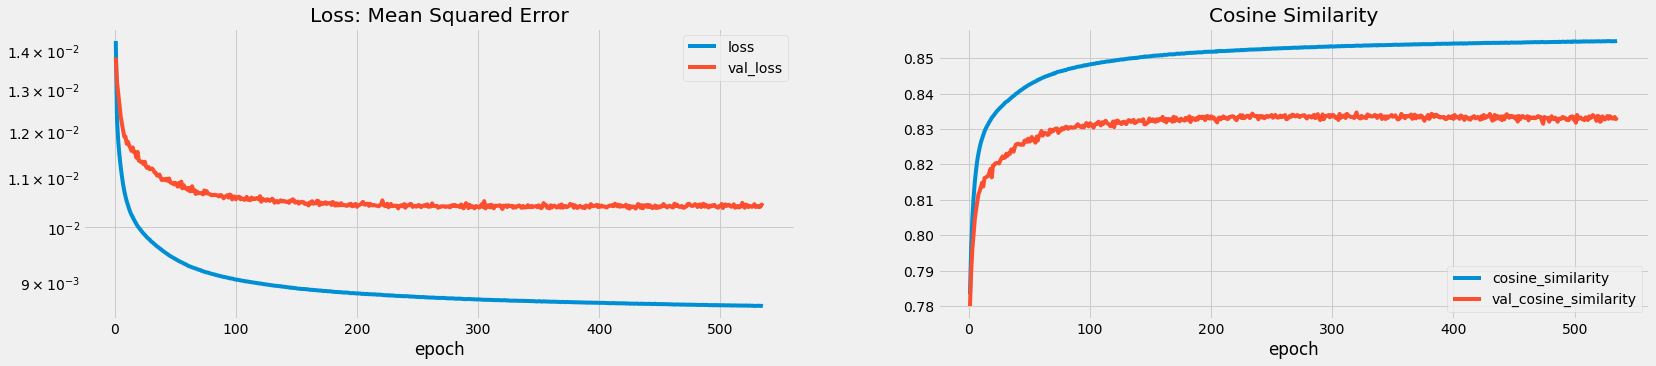

time elapsed: 7750.597425460815
Epoch 536/100000
2503/2503 [==============================] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086 - root_mean_squared_error: 0.0926 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 680.5184 - mean_squared_logarithmic_error: 0.0025 - cosine_similarity: 0.8555

KeyboardInterrupt: 

In [24]:
custom_callback = CustomCallback(model_name=model_name,save_dir=save_dir)

with tf.device('/gpu:0'):  
  history = model.fit(X_train_scaled,
                    Y_train_scaled,
                    epochs=100000,
                    batch_size=batch_size,
                    validation_data=(X_test_scaled,Y_test_scaled),
                    callbacks=[custom_callback]
                    )

print("loss",history.history['loss'][-1])
print("cosine_similarity",history.history['cosine_similarity'][-1])
print("val_loss",history.history['val_loss'][-1])
print("val_cosine_similarity",history.history['val_cosine_similarity'][-1])

# Simple Prediction Evaluation

In [ ]:
model.evaluate(X_test_scaled,Y_test_scaled)

In [ ]:
# Y_test_pred = model.predict(X_test_scaled)
# Y_test_true = Y_test_scaled

view_length = 300
view_landmark = np.random.randint(107)
plt.title('landmark: ' + str(view_landmark))
pos = np.random.randint(len(Y_test_pred)-view_length)
plt.plot(Y_test_true[pos:pos+view_length,view_landmark], label="true")
plt.plot(Y_test_pred[pos:pos+view_length,view_landmark], label="pred")
plt.legend()


# Prediction and save the result (WIP)


In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from scipy.signal import butter, sosfilt


def custom_scale(arr, a, b):
    return arr*a + b


def custom_inverse_scale(arr, a, b):
    return (arr-b)/a


# create labels
landmark_indexes = [5, 6, 7, 8, 31, 32, 33, 48,
                    49, 50, 51, 57, 58, 59, 60, 61, 62, 66, 67]
center_indexes = [8, 33, 51, 57, 62, 66]
landmark_labels = ["X_"+str(i)
                   for i in landmark_indexes if i not in center_indexes]
landmark_labels += ["Y_"+str(i) for i in landmark_indexes]
landmark_labels += ["Z_"+str(i) for i in landmark_indexes]

# mirror landmark pair
mirror_landmark_pair = [[9,7], [10,6], [11,5], [34,32], [35,31], [52,50], 
                        [53,49], [54,48], [55,59], [56,58], [63,61], [64,60], [65,67]]

# all indexes
all_indexes = [5, 6, 7, 8, 9, 10, 11, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52,
               53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
                


# audio params
frame_length = 0.02  # 20ms
audio_sample_rate = 44100
hop_length = int(audio_sample_rate*frame_length)  # 882 frames for 20 ms

# import model
model_name = "GRU"
save_dir = "/home/alkhemi/Documents/thesis/saved_model/"
model = tf.keras.models.load_model(
    save_dir + model_name + "/"+'GRU-184-0.0127.h5')
model.summary()

# get scale coefs
npy_data_dir = "/home/alkhemi/Documents/thesis/npy_data/"
x_scale_coefs = np.load(npy_data_dir+"s01_x_scale_coef.npy")
y_scale_coefs = np.load(npy_data_dir+"s01_y_scale_coef.npy")

# create noise filter
sos = butter(13, [60, 8000], output='sos', btype='bandpass', fs=44100)

audio_dir = "/home/alkhemi/Documents/thesis/evaluation/test/"
audio_paths = [audio_dir +
               item for item in os.listdir(audio_dir) if item[-4:] == ".wav"]
audio_paths.sort()
# print(len(audio_paths))

output_dir = "/home/alkhemi/Documents/thesis/evaluation/test/"
filename_prefix = ""
filename_suffix = "_"+model_name


for audio_path in audio_paths:
    print("processing", audio_path)
    # load audio (mono)
    audio_array, sr = librosa.load(
        audio_path, sr=audio_sample_rate, mono=True)

    # noise filter
    audio_array_filtered = sosfilt(sos, audio_array)

    # get mfcc
    MFCCs = librosa.feature.mfcc(
        audio_array_filtered,
        sr=sr,
        n_fft=512,  # window size
        hop_length=hop_length,
        n_mfcc=13,  # num of coefficients
        n_mels=40,  # num of mel band filters
        window="hann",
        htk=True,
    ).transpose()

    # scale
    scaled_MFCCs = np.zeros(shape=MFCCs.shape, dtype="float16")
    for i in range(13):
        scaled_MFCCs[:, i] = custom_scale(
            arr=MFCCs[:, i],
            a=x_scale_coefs[i, 0],
            b=x_scale_coefs[i, 1])

    # get landmark predict
    landmarks_dis_scaled = model.predict(
        np.expand_dims(scaled_MFCCs, axis=0))[0]

    # inverse scale
    landmarks_displacement = np.zeros(
        shape=landmarks_dis_scaled.shape, dtype='float16')
    for i in range(51):
        landmarks_displacement[:, i] = custom_inverse_scale(
            arr=landmarks_dis_scaled[:, i],
            a=y_scale_coefs[i, 0],
            b=y_scale_coefs[i, 1])
    
    # create dataframe and generate other half of the face
    df = pd.DataFrame()
    # make sure all data exists
    for axis in ["X_","Y_","Z_"]:
      for i in all_indexes:
        df[axis+str(i)] = [0]*landmarks_displacement.shape[0]

    # left side landmarks
    for i in range(len(landmark_labels)):
      df[landmark_labels[i]] = landmarks_displacement[:,i]

    # the other half
    for pair in mirror_landmark_pair:
      df["X_"+str(pair[0])] = -df["X_"+str(pair[1])]
      df["Y_"+str(pair[0])] = df["Y_"+str(pair[1])]
      df["Z_"+str(pair[0])] = df["Z_"+str(pair[1])]
    
    # make sure x value of center landmark is zero
    for i in center_indexes:
      df["X_"+str(i)] = [0]*len(df)

    # save csv
    filename = audio_path.split("/")[-1].split(".")[-2]
    df.to_csv(output_dir + filename_prefix + filename + filename_suffix
              + "_pred.csv", index=False, float_format='%.3f')
    del audio_array, sr, audio_array_filtered, MFCCs, scaled_MFCCs
    del landmarks_dis_scaled, landmarks_displacement
    gc.collect()